<a href="https://colab.research.google.com/github/JARVIS3954P/WASTE_CLASSIFICATION/blob/main/wasterclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/Kaggle/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download techsash/waste-classification-data

In [ ]:
! unzip /content/waste-classification-data.zip

## Waster Classification using CNN Model

In [ ]:
pip install opencv-python

In [ ]:
! pip install tensorflow
! pip install tensorboard

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

In [11]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [12]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [13]:
train_path = "DATASET/TRAIN"
test_path = "DATASET/TEST"

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Still needed for *augmentation*
from tensorflow.keras.utils import plot_model, image_dataset_from_directory # Import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from glob import glob
import os # Import os

In [28]:
# Visualization

from cv2 import cvtColor

x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/**')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        x_data.append(img_array)
        y_data.append(category.split('/')[-1])

data = pd.DataFrame({'image':x_data, 'label':y_data})

100%|██████████| 9999/9999 [00:05<00:00, 1897.16it/s]


In [29]:
data.shape

(22564, 2)

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
print(data.label.value_counts())  # See the exact values


label
O    12565
R     9999
Name: count, dtype: int64


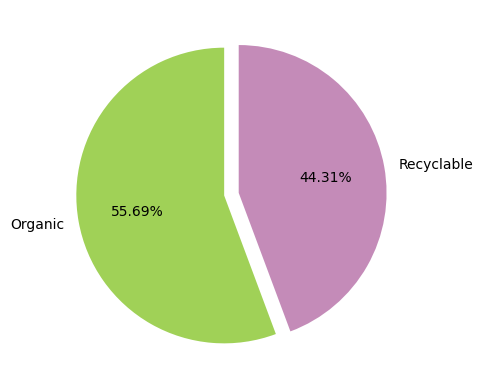

In [32]:
colors = ['#a0d157', '#c48bb8']

plt.pie(data.label.value_counts(), labels=['Organic', 'Recyclable'], autopct='%0.2f%%', colors=colors, startangle=90, explode=[0.05, 0.05])
plt.show()

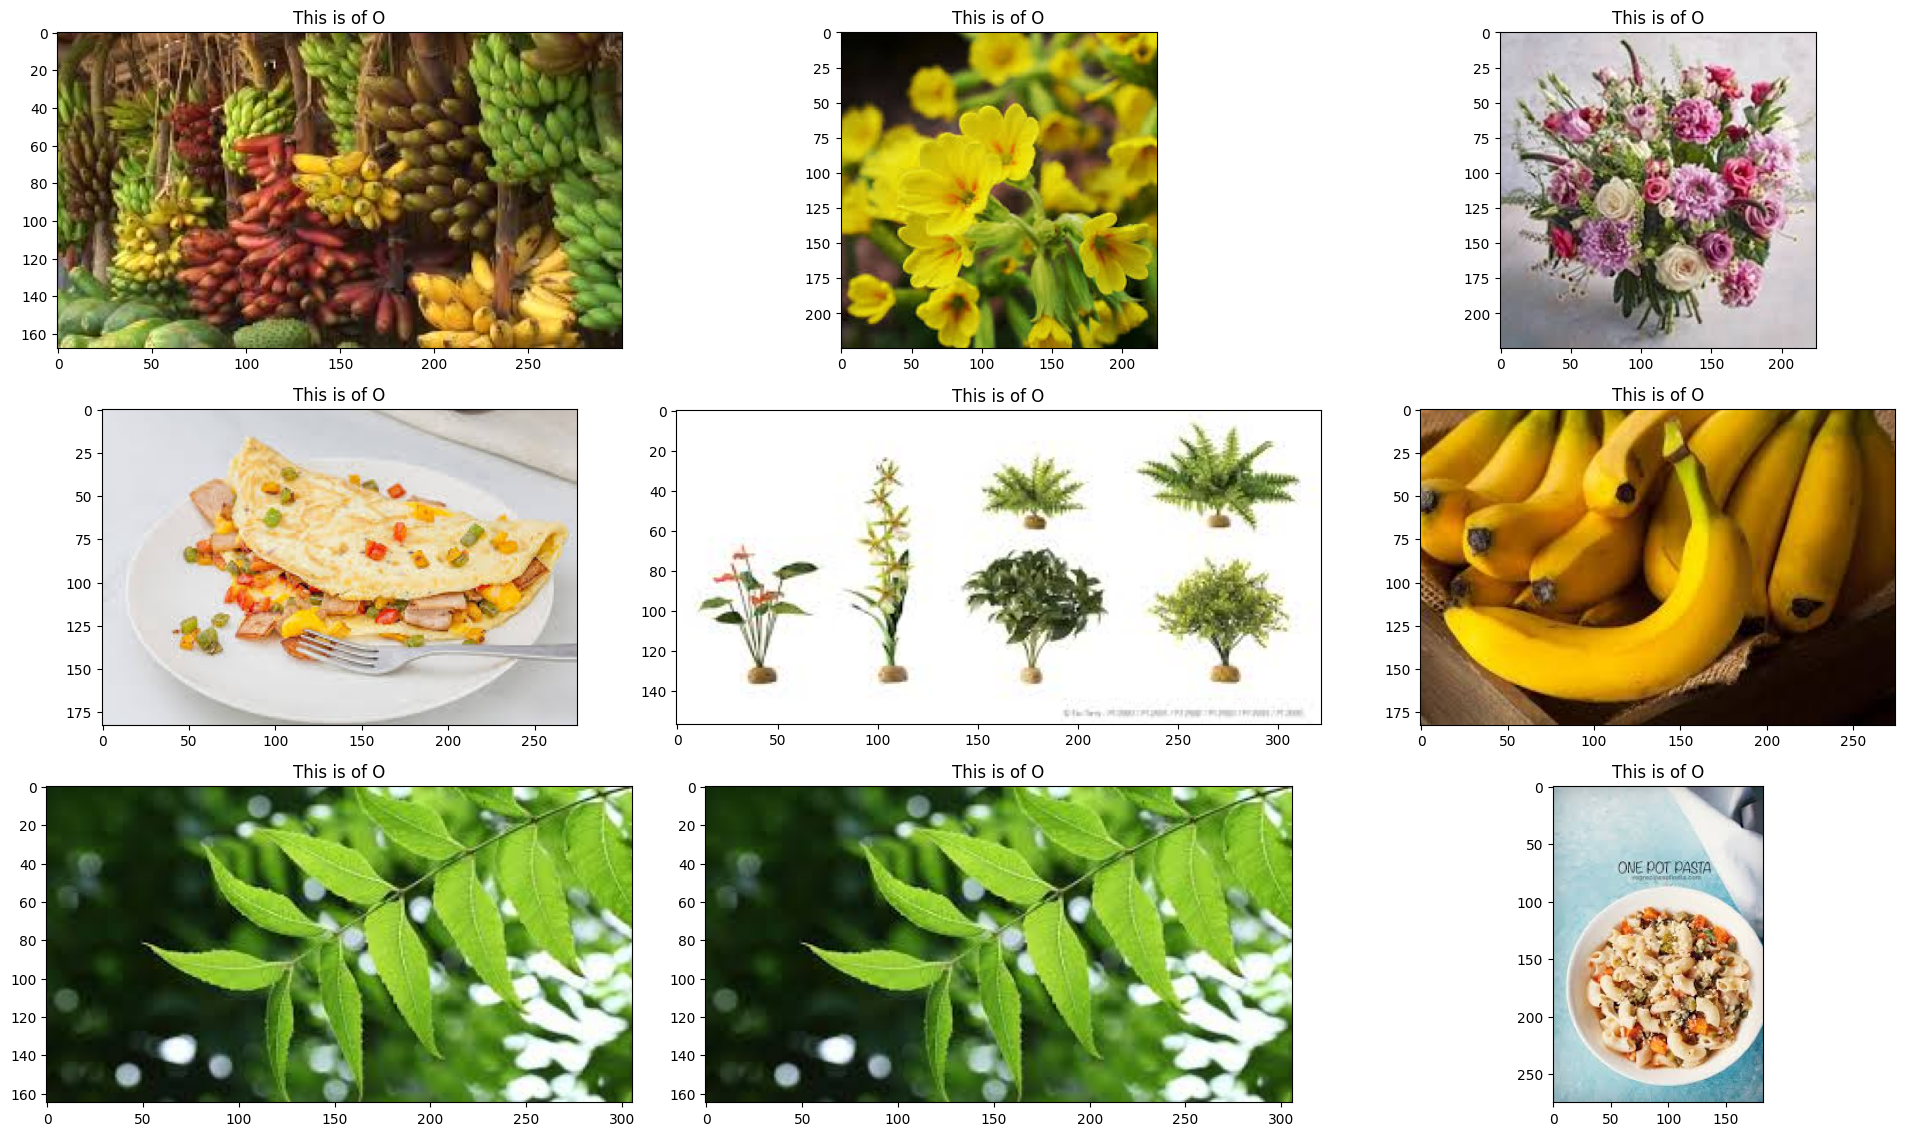

In [33]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index = np.random.randint(1500)
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

## CNN - Convolutional Neural Network

In [34]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
batch_size = 128  # Experiment with this!
image_size = (224, 224)

In [40]:
train_ds = image_dataset_from_directory(
    train_path,
    validation_split=0.2,  # Use a validation split directly here
    subset="training",
    seed=123,  # For reproducibility
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical' # Keep this for one-hot encoding
)

val_ds = image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory(
    test_path,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 22564 files belonging to 2 classes.
Using 18052 files for training.
Found 22564 files belonging to 2 classes.
Using 4512 files for validation.
Found 2513 files belonging to 2 classes.


In [44]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test data


In [45]:
train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',  # Use subset for train/validation split
    seed=123
)

val_ds = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',  # Use subset for train/validation split
    seed=123
)


test_ds = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data for consistent results
)

Found 22564 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [46]:
from tensorflow.keras.optimizers import Adam
model = Sequential()

#First Conv. Block
model.add(Conv2D(32, (3,3), kernel_initializer='he_normal', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())

#Second Conv. Block
model.add(Conv2D(64, (3,3), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())

#Third Conv. Block
model.add(Conv2D(128, (3,3), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())

#Fourth Conv. Block
model.add(Conv2D(256, (3,3), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())

#Fully Connected Layer
model.add(Flatten())

model.add(Dense(256, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss = "binary_crossentropy",
                optimizer=Adam(learning_rate=0.0005),
                metrics = ["accuracy"])
batch_size = 128

In [ ]:
model.summary()

In [48]:
# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

# Create a logs directory if it doesn't exist
if not os.path.exists("logs"):
    os.makedirs("logs")
tensorboard = TensorBoard(log_dir="./logs")

In [50]:
hist = model.fit(
    train_ds,  # Changed to train_ds
    epochs=20,  # Start small, then increase
    validation_data=test_ds,  # Changed to test_ds
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard]
)

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7888 - loss: 0.4938
Epoch 1: val_accuracy improved from -inf to 0.59729, saving model to best_model.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.7890 - loss: 0.4935 - val_accuracy: 0.5973 - val_loss: 1.0937 - learning_rate: 5.0000e-04
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8476 - loss: 0.3863
Epoch 2: val_accuracy improved from 0.59729 to 0.80820, saving model to best_model.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8476 - loss: 0.3862 - val_accuracy: 0.8082 - val_loss: 0.4512 - learning_rate: 5.0000e-04
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8659 - loss: 0.3448
Epoch 3: val_accuracy improved from 0.80820 to 0.82332, saving model to best_model.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.8659 - loss: 0.3448 - val_accuracy: 0.8233 - val_loss: 0.4927 - learning_rate: 5.0000e-04
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8635 - loss: 0.3397
Epoch 4: val_accuracy improved from 0.82332 to 0.88102, saving model to best_model.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8635 - loss: 0.3397 - val_accuracy: 0.8810 - val_loss: 0.3410 - learning_rate: 5.0000e-04
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8680 - loss: 0.3260
Epoch 5: val_accuracy did not improve from 0.88102
177/177 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.8680 - loss: 0.3260 - val_accuracy: 0.8062 - val_loss: 0.7579 - learning_rate: 5.0000e-04
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8667 - loss: 0.3243
Epoch 6: val_accuracy improved from 0.88102 to 0.88938, saving model to best_model.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8667 - loss: 0.3242 - val_accuracy: 0.8894 - val_loss: 0.2840 - learning_rate: 5.0000e-04
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8785 - loss: 0.3099
Epoch 7: val_accuracy improved from 0.88938 to 0.90529, saving model to best_model.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.8785 - loss: 0.3099 - val_accuracy: 0.9053 - val_loss: 0.2567 - learning_rate: 5.0000e-04
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8785 - loss: 0.2990
Epoch 8: val_accuracy did not improve from 0.90529
177/177 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8785 - loss: 0.2990 - val_accuracy: 0.8973 - val_loss: 0.2537 - learning_rate: 5.0000e-04
Epoch 9/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8823 - loss: 0.2919
Epoch 9: val_accuracy did not improve from 0.90529
177/177 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.8823 - loss: 0.2920 - val_accuracy: 0.8627 - val_loss: 0.3510 - learning_rate: 5.0000e-04
Epoch 10/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8845 - loss: 0.2907
Epoch 10: val_accuracy did not improve from 0.90529
177/177 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8845 - loss: 0.2907 - val_accuracy: 0.8245 - val_loss: 0.4390 - learning_rate: 5.0000e-04
Epoch 

177/177 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8934 - loss: 0.2683 - val_accuracy: 0.9148 - val_loss: 0.2206 - learning_rate: 1.0000e-04
Epoch 15/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8990 - loss: 0.2603
Epoch 15: val_accuracy did not improve from 0.91484
177/177 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.8990 - loss: 0.2603 - val_accuracy: 0.9009 - val_loss: 0.2612 - learning_rate: 1.0000e-04
Epoch 16/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9013 - loss: 0.2495
Epoch 16: val_accuracy did not improve from 0.91484
177/177 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9013 - loss: 0.2495 - val_accuracy: 0.9121 - val_loss: 0.2364 - learning_rate: 1.0000e-04
Epoch 17/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9047 - loss: 0.2490
Epoch 17: val_accuracy did not improve from 0.91484
177/177 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9046 - loss: 0.2490 - val_accuracy: 0.9065 - val_loss: 0.2366 - learning_rate: 1.0000e-04
Ep


Epoch 19: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
177/177 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.9090 - loss: 0.2393 - val_accuracy: 0.9176 - val_loss: 0.2230 - learning_rate: 1.0000e-04
Epoch 20/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9043 - loss: 0.2459
Epoch 20: val_accuracy did not improve from 0.91763
177/177 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9043 - loss: 0.2459 - val_accuracy: 0.9172 - val_loss: 0.2227 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 14.


In [51]:
# Load best weights (after training)
model.load_weights("best_model.h5")

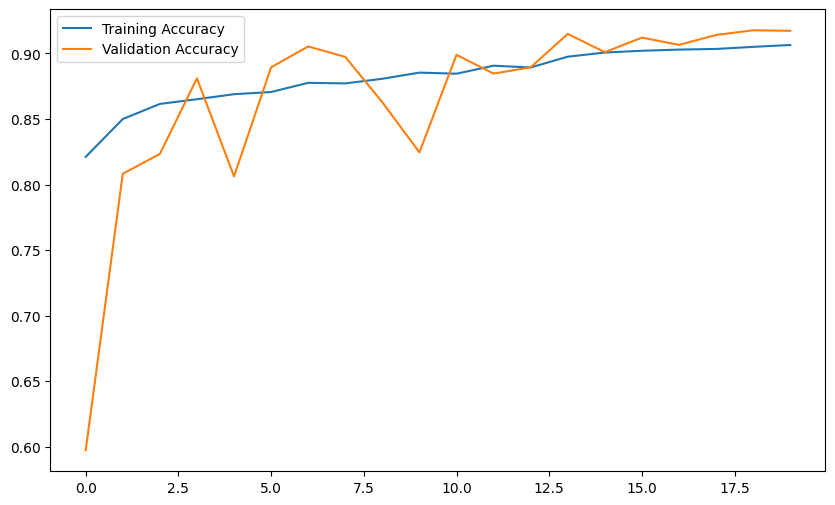

In [52]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

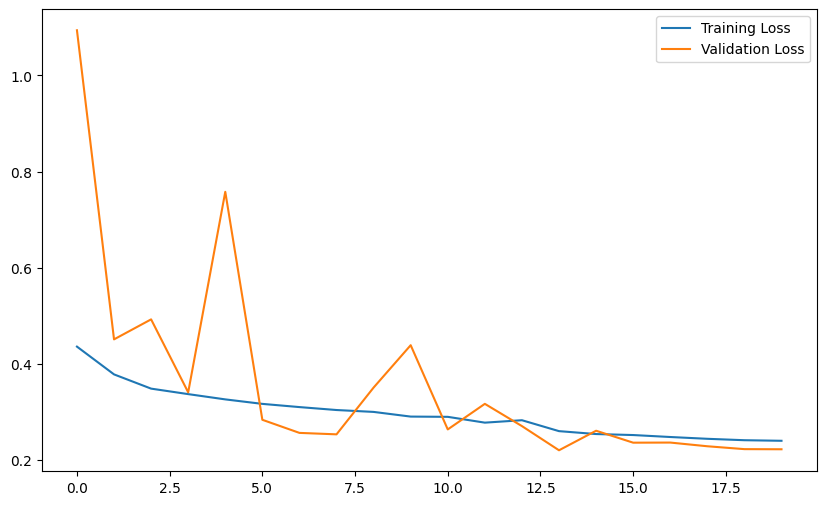

In [53]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [56]:
# Prediction function
def predict_fun(img_path):
    # img = cv2.imread(img_path)  # Removed this line as img_path is already an image
    img = img_path  # Use the image directly

    if img is None:
        print(f"Error: Could not read image at {img_path}")
        return

    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()

    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, (-1, 224, 224, 3))
    img = img / 255.0   # Normalize

    result = np.argmax(model.predict(img))
    if result == 0:
        print('The image is recyclable')
    elif result == 1:
        print('The image is organic')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
The image is organic


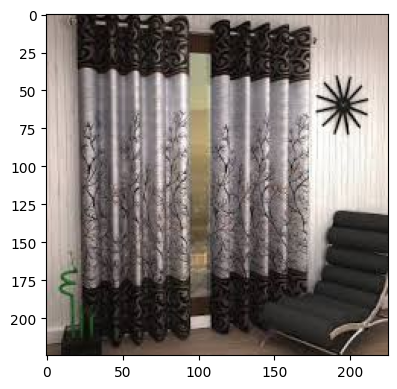

In [58]:
test_img = cv2.imread('/content/DATASET/TEST/R/R_10040.jpg')
predict_fun(test_img)